Try to compute DCR for a given SED.

We're going to play with estimating the DCR for a SN Ia along its light curve.

To setup, just set up `lsst_apps` and `chroma`.

Need to also get the `chroma` repo and symlink to its `data` directory (it has a copy of some kind of SN Ia time-series spectrum).

In [2]:
import os
import numpy as np

from chroma import dcr
from chroma import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

datadir = './data/'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')

## see http://matplotlib.org/users/colormaps.html for colormaps
from matplotlib import cm

In [3]:
import pandas as pd

## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

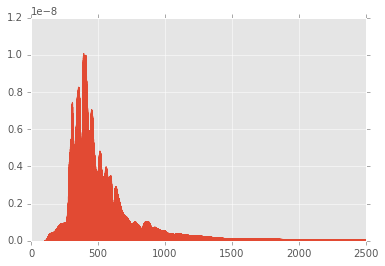

In [4]:
from scipy.interpolate import interp1d

tmp,w,f = np.genfromtxt(datadir+'SEDs/snflux_1a.dat').T
w /= 10. ## convert from angstroms to nm?
ss = interp1d(w, f)

sn_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = sn_SED(wave)

plt.plot(ss.x, ss.y)

Aha, the SN Ia spec is multiple spectra - let's extract all of them and set to $z=0.5$ (first few look weird).

In [5]:
#print np.where(w == w.max())[0]
sn_SEDs = []
val_prev = 0
for ind,val in enumerate(np.where(w == w.max())[0]):
    #print ind,val
    ww = w[val_prev:val]
    ff = f[val_prev:val]
    ss = interp1d(ww, ff)
    sed = spec.SED(ss).atRedshift(0.5)
    sn_SEDs.append(sed)
    val_prev = val + 1

print len(sn_SEDs) 
#plt.plot(w[252105:254506], f[252105:254506])

106


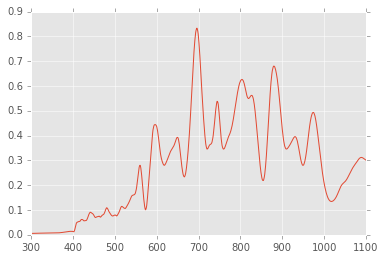

In [6]:
sn_SED = sn_SEDs[100] #spec.SED(ss).atRedshift(0.5)
wave = np.arange(300.0, 1101.0, 1.0)
photons = sn_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 900)].max()
plt.plot(wave, photons/scale)

Looks like spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


Sa galaxy at redshift 0.5

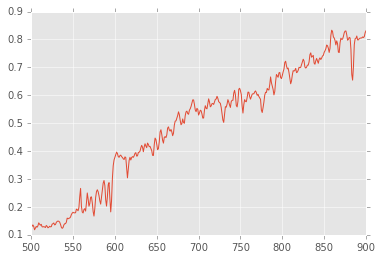

In [7]:
#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt(datadir+'SEDs/KIN_Sa_ext.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss).atRedshift(0.5)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)

Make a relative DCR curve for SN Ia along its light curve (assume ZD angle 20 deg.)

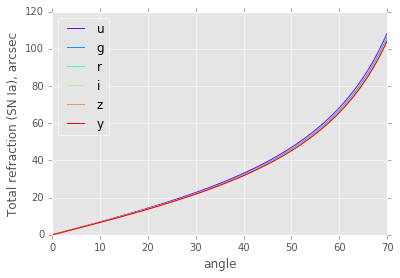

In [8]:
# filters are stored in two columns: wavelength (nm), and throughput

def compute_dcr(SED, filters='ugrizy', angles=np.linspace(0,70,71), relative=None, **kwargs):
    if type(angles) is int or type(angles) is float:
        angles = np.array([angles])
    elif type(angles) is list:
        angles = np.array(angles)        
    if type(filters) is int or type(filters) is float:
        filters = np.array([filters])
    df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
    for i, filter_ in enumerate(filters):
        if type(filter_) is str:
            fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
            fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
            shifts = np.array( [SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0, **kwargs)[0].item(1) 
                            for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
        else: # assume it's a single wavelength value (nm) then
            shifts = np.array( [dcr.get_refraction(filter_, zenith=angle * np.pi/180.0, **kwargs) for angle in angles])
            shifts = shifts * 3600.0 * 180.0/np.pi            
            df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
             
    df.columns = np.insert(np.array(list(filters), dtype='S6'), 0, 'angle')
    df = df.set_index('angle')
    if relative is not None and np.any(df.columns.values == relative):
        df2 = df.copy().sub(df[relative], axis=0)
        return df2
    else:
        return df

angles = np.linspace(0,70,71)

DCRs = compute_dcr(sn_SED, 'ugrizy', angles)
ax = DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (SN Ia), arcsec')

#DCRs = compute_dcr(sn_SED, 'ugrizy', angles, relative='r')
#ax = DCRs.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

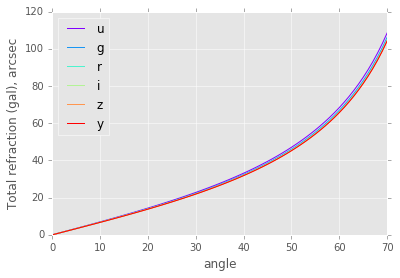

In [9]:
DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles)
ax = DCRs_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction (gal), arcsec')

#DCRs_gal = compute_dcr(gal_SED, 'ugrizy', angles, relative='r')
#ax = DCRs_gal.plot(colormap=cm.rainbow)
#ax.set_ylabel('Relative refraction, arcsec')

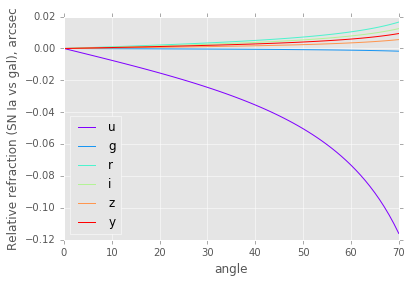

In [10]:
df_tmp = DCRs - DCRs_gal
sizeme(df_tmp.head())
ax = df_tmp.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs gal), arcsec')

In [11]:
sizeme(compute_dcr(sn_SED, 'ugrizy', 20.))

,u,g,r,i,z,y
angle,,,,,,
20.0,14.356802,14.06186,13.925262,13.862969,13.826746,13.807054


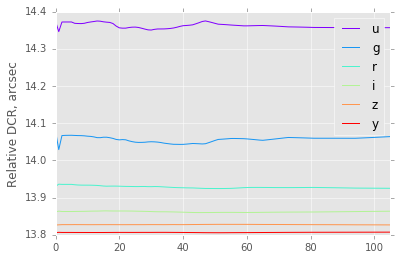

In [12]:
#sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20., relative='r') for SED in sn_SEDs])
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 20.)
ax = sn_DCRs.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative DCR, arcsec')
#sizeme(sn_DCRs)

DCR of SN Ia along light curve at zenith angle of 20 deg. as a function of time:

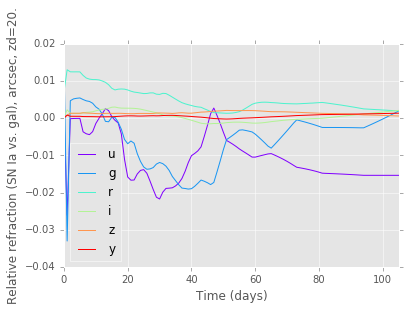

In [13]:
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 20.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 20.)

tmp_df = sn_DCRs - gal_DCR.values.squeeze()
ax = tmp_df.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs. gal), arcsec, zd=20.')
ax.set_xlabel('Time (days)')

Try it at zenith angle 40 deg. - doesn't seem to differ much from 20 deg.

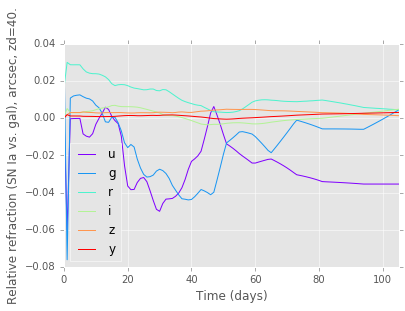

In [14]:
sn_DCRs = pd.concat([compute_dcr(SED, 'ugrizy', 40.) for SED in sn_SEDs])
sn_DCRs = sn_DCRs.set_index(np.arange(len(sn_SEDs)))
gal_DCR = compute_dcr(gal_SED, 'ugrizy', 40.)

tmp_df = sn_DCRs - gal_DCR.values.squeeze()
ax = tmp_df.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction (SN Ia vs. gal), arcsec, zd=40.')
ax.set_xlabel('Time (days)')

## Load the airmassDist table from Rahul (which sims run?)

In [86]:
import gzip
tab = pd.read_csv(gzip.GzipFile('airmassDist.csv.gz', 'rb'))
sizeme(tab.head())

,obsHistID,ditheredRA,ditheredDec,airmass,altitude,azimuth,fiveSigmaDepth
0,1,1.643930,-1.108924,1.463594,0.752207,2.595265,21.021236
1,2,1.664257,-1.060423,1.454958,0.757776,2.528319,21.026646
2,3,1.680878,-1.011722,1.448796,0.761808,2.460833,21.030520
3,4,1.694604,-0.962927,1.445307,0.764113,2.393012,21.032718
4,5,1.706054,-0.914123,1.444491,0.764655,2.325132,21.033233


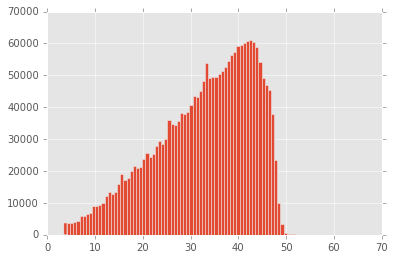

In [93]:
# altitude in radians, convert to zenith angle in degrees.
zd = 90. - tab.altitude.values * 180. / np.pi
plt.hist(zd, bins=100);

Let's make a set of contour plots of refraction vs (days, zenith distance) for `u`, `g`, `r`.

Looks like zd barely ever gets higher than 50 deg. so cut it off there.

In [100]:
print np.sum(zd > 50.), np.mean(zd > 50.)

926 0.000421886140858


In [94]:
def plot_sn_dcr_contour(filt='g', angles=np.linspace(0,50,51)):
    sn_DCRs = pd.concat([compute_dcr(SED, filt, angles=angles) for SED in sn_SEDs], 
                        axis=1)
    gal_DCR = compute_dcr(gal_SED, filt, angles=angles)
    
    tmp = (sn_DCRs.values - gal_DCR.values) / 0.2  # pixel scale (pix per arcsec)
    levels = np.arange(-1., 1., 0.1)
    fig = plt.imshow(tmp, interpolation='none', origin='lower', cmap=cm.rainbow)
    cs = plt.contour(tmp, origin='lower', linewidths=1, colors='k', levels=levels)
    plt.clabel(cs, levels, inline=1, fmt='%.1f', fontsize=14, colors='k')
    plt.title('DCR (pixels), ' + filt)
    plt.xlabel('Time (d.)')
    plt.ylabel('Zenith angle (deg.))')
    return tmp

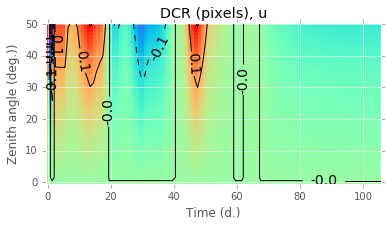

In [95]:
plot_sn_dcr_contour(filt='u');

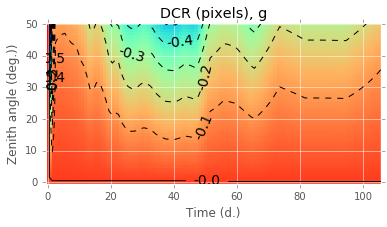

In [96]:
plot_sn_dcr_contour(filt='g');

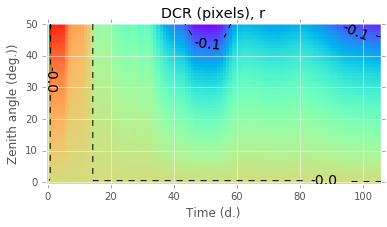

In [97]:
plot_sn_dcr_contour(filt='r');

# Irrelevant stuff...

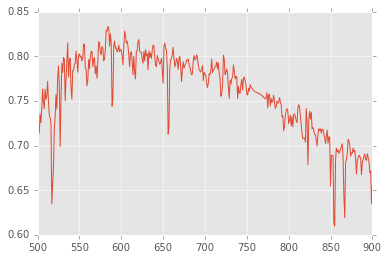

In [16]:
from scipy.interpolate import interp1d

#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt(datadir+'SEDs/ukg5v.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)